## Aligning PACE and EMIT Data
Adapted from "Projecting & GeoTIFF" tutorial on OB.DAAC's [Help Hub][help-hub] and from LP.DAAC's [VITALS][vitals] "Working with EMIT L2A Reflectance and ECOSTRESS L2 LSTE" tutorial.

Author: Skye Caplan (NASA, SSAI)
Last updated: 01/07/2026

<div class="alert alert-info" role="alert">

An [Earthdata Login][edl] account is required to access data from the NASA Earthdata system, including NASA PACE and EMIT data.

</div>

[edl]: https://urs.earthdata.nasa.gov/
[oci-data-access]: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/
[emit-data-access]: https://nasa.github.io/VITALS/python/Exploring_EMIT_L2A_RFL.html
[help-hub]: https://nasa.github.io/oceandata-notebooks/
[vitals]: https://nasa.github.io/VITALS/

## Summary

This notebook will use the data downloaded from `01_Colocate_PACE_EMIT_data.ipynb` and the `rasterio` and `rioxarray` packages to put PACE and EMIT data on the same grid. We will use tools from LPDAAC's VITALS tutorials to orthorectify the EMIT data, and then place PACE and EMIT granules on a generalized grid using OCI's coarser resolution. We can then compare the data from the two sensors. These techniques will also be integral to our burn scar analysis in `03_NBR_with_PACE_EMIT.ipynb`.

## Learning Objectives

At the end of this notebook, you will know how to:
- Open and orthorectify an EMIT granule
- Take PACE L2 data from the instrument swath to a defined grid
- Downscale EMIT to PACE resolution
- Compare spectra between sensors

## Contents
1. [Setup](#1.-Setup)
2. [Gridding EMIT Data](#2.-Gridding-EMIT-Data)
3. [Projecting PACE Data onto a Defined Grid](#3.-Projecting-PACE-Data-onto-a-Defined-Grid)
4. [Aligning PACE and EMIT Grids ](#4.-Aligning-PACE-and-EMIT-Grids)
5. [Comparing the Data](#5.-Comparing-the-Data)


## 1. Setup

Begin by importing all of the packages used in this notebook.

In [1]:
import rasterio 
import cf_xarray 
import cartopy
import xarray as xr 
import numpy as np 
import cartopy.crs as ccrs 
import rioxarray as rio
import pace_tools as pace
import emit_tools as emit
import matplotlib.pyplot as plt 
from rasterio.enums import Resampling
from rasterio.crs import CRS

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

def plot_features(ax, gridline_alpha=1):
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, linewidth=0.25, alpha=gridline_alpha)
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cartopy.feature.OCEAN, edgecolor="w", linewidth=0.01)
    ax.add_feature(cartopy.feature.LAND, edgecolor="w", linewidth=0.01)
    ax.add_feature(cartopy.feature.LAKES, edgecolor="w", linewidth=0.01)

In the last notebook, we found and downloaded specific granules from before and after January #### 2025 to begin analyzing the LA wildfires. We'll be using those files for the rest of the tutorials in this series, and so define their paths for this notebook in the cell below.

In [2]:
# These are local paths from the first tutorial
# if necessary, grab this one too and mosaic for before: EMIT_L2A_RFL_001_20240825T173104_2423811_007
# NOTE: Find a good place to put these and pull them in? text file maybe
emit_paths = ["data/EMIT_L2A_RFL_001_20240825T173115_2423811_008.nc", # before
              "data/EMIT_L2A_RFL_001_20250324T220953_2508314_003.nc", # after
              "data/EMIT_L2A_MASK_001_20240825T173115_2423811_008.nc",
              "data/EMIT_L2A_MASK_001_20250324T220953_2508314_003.nc"] 
oci_path = ["data/PACE_OCI.20241218T202231.L2.SFREFL.V3_1.nc",        # before
            "data/PACE_OCI.20250113T204049.L2.SFREFL.V3_1.nc"]        # after

Recall from the previous tutorial that these are Level-2 (L2) data. An important aspect of L2 data from any sensor is that that they are still in the instrument swath, meaning they are not on any predefined grid. Comparing the raw datasets, even doing so with two granules from the same sensor, would be inaccurate because the pixels do not represent the same location on the Earth. Especially because the eventual goal of this tutorial series is to compare data between sensors, we need to make sure our pixel centres have the same latitudes and longitudes - in other words, we have to grid our data.

To accomplish this gridding, we have to treat EMIT and PACE slightly differently. The EMIT L2A reflectance file comes with a geometry lookup table (GLT) in addition to the latitude and longitude of each pixel, which allows us to reproject the raw EMIT data onto a geographic grid. L2 Data from PACE does not have a GLT, so we will have to use another technique to project the data. 

The [VITALS][vitals] repository provides the `emit_tools` module which includes several functions to ease working with EMIT data. We'll use these first to orthorectify those data. More information can be found in the [EMIT-Data-Resources repository](https://github.com/nasa/EMIT-Data-Resources)

<div class="alert alert-warning" role="alert">

Should we orthorectify EMIT first and the reproject it again on the PACE grid? Probably, because will calc. nbr and then reproject up...

</div>

[vitals]: https://nasa.github.io/VITALS/

### 2. Gridding EMIT Data

The `emit_xarray` function in the `emit_tools` module is what will allow us to grid EMIT data. The `ortho=True` argument in the cell below tells the function to use the GLT to orthorectify the specific scene we feed it. Since we need both a "before" and "after" image to complete the burn analysis in the next tutorial(link when avail), we'll do this which each EMIT scene defined above.

We'll also mask out any fill values in the EMIT data by setting them to NaNs.

In [3]:
emit_pre = emit.emit_xarray(emit_paths[0], ortho=True)
emit_post = emit.emit_xarray(emit_paths[1], ortho=True)

emit_pre['reflectance'].data[emit_pre['reflectance'].data == -9999] = np.nan
emit_post['reflectance'].data[emit_post['reflectance'].data == -9999] = np.nan

EMIT data also comes with a quaity mask, which we will apply to the data. These also have to be orthorectified, and we can use the same function as above. Once we have the mask data, we can see which flags are provided in the mask. 

In [4]:
emit_pre_mask = emit.emit_xarray(emit_paths[2], ortho=True)
emit_post_mask = emit.emit_xarray(emit_paths[3], ortho=True)

emit_pre_mask['mask'].data[emit_pre_mask['mask'].data == -9999] = np.nan
emit_post_mask['mask'].data[emit_post_mask['mask'].data == -9999] = np.nan

emit_pre_mask.mask_bands.data.tolist()

['Cloud flag',
 'Cirrus flag',
 'Water flag',
 'Spacecraft Flag',
 'Dilated Cloud Flag',
 'AOD550',
 'H2O (g cm-2)',
 'Aggregate Flag']

The `Aggregate Flag` is a aggregation of the first 5 data quality flags listed above, so we will use that to mask our reflectance data. 

In [5]:
# NOTE: Can we use the quality_mask or band_mask EMIT tool to note use the dilated cld mask?
emit_pre_mask = emit_pre_mask.sel(mask_bands='Aggregate Flag')
emit_post_mask = emit_post_mask.sel(mask_bands='Aggregate Flag')

emit_pre["reflectance"].data[emit_pre_mask["mask"].data == 1] = np.nan
emit_post["reflectance"].data[emit_post_mask["mask"].data == 1] = np.nan

Now we can plot these data to verify they're gridded and cloud masked. 

<div class="alert alert-warning" role="alert">

Note that the "after" image doesn't seem to mask out water correctly?? or clouds?
ALSO  we have to regrid EMIT for any of this to work! So have to generalize the grid fcn

</div>

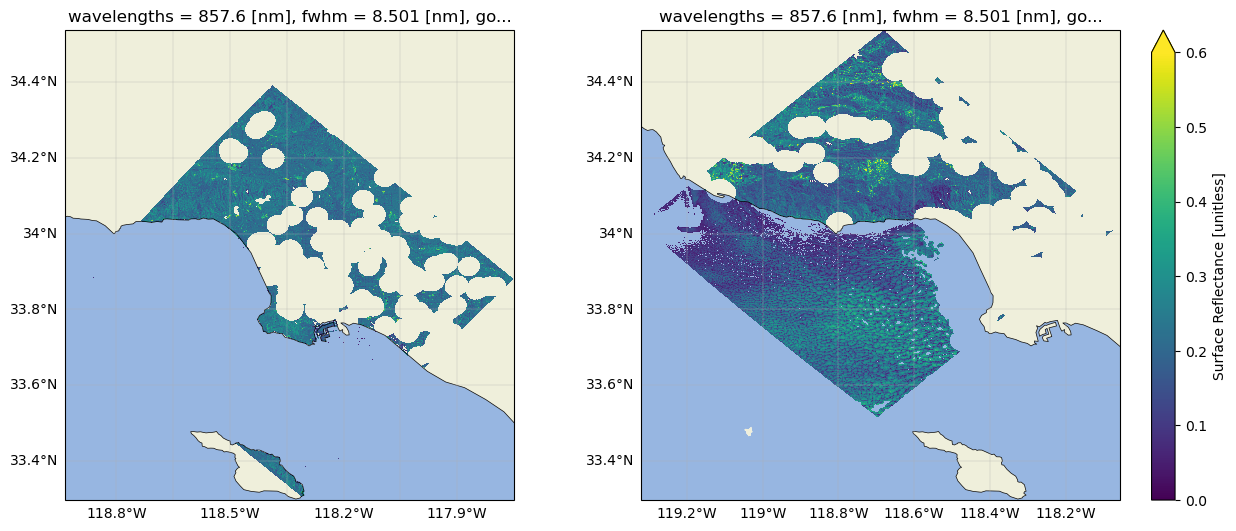

In [6]:
fig, ax = plt.subplots(1,2, figsize=(13,5),sharey=True, 
                       subplot_kw={"projection": ccrs.PlateCarree()})
fig.tight_layout()
emit_pre["reflectance"].sel(wavelengths=860, method="nearest").plot(ax=ax[0],vmin=0, vmax=0.6, add_colorbar=False)
emit_post["reflectance"].sel(wavelengths=860, method="nearest").plot(ax=ax[1],vmin=0, vmax=0.6)
plot_features(ax[0])
plot_features(ax[1])
plt.show()

Our EMIT granules are now orthorectified and masked, but we still need to grid them in order for the pixels to match in space. 

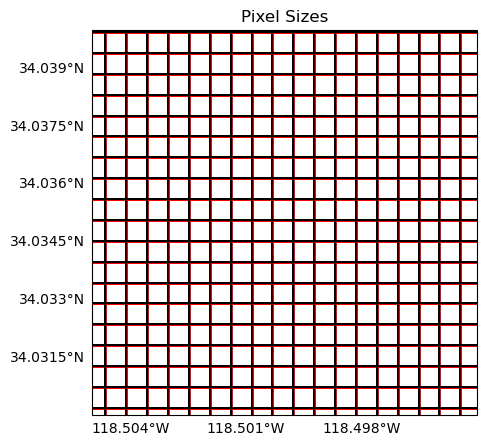

In [7]:
# TODO: Grid EMIT data!!
fig, ax = plt.subplots(figsize=(13,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
emit_pre.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=-1, vmax=0, cmap="Greys_r", transform=ccrs.PlateCarree(),linewidth=2, edgecolors="red", add_colorbar=False)
emit_post.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="viridis", transform=ccrs.PlateCarree(),  linewidth=0.05, edgecolors="k", add_colorbar=False, alpha=1)
ax.set_extent([-118.505, -118.495, 34.03, 34.04])
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, alpha=0.0)
ax.set_title("Pixel Sizes")
plt.show()

In [8]:
t1 = emit_pre.sel({"latitude":34.07, "longitude":-118.50}, method="nearest")
print(f"{t1.longitude.data}, {t1.latitude.data}")
t2 = emit_post.sel({"latitude":34.07, "longitude":-118.50}, method="nearest")
print(f"{t2.longitude.data}, {t2.latitude.data}")

-118.50004229560727, 34.0700433074108
-118.50004229560773, 34.070043307410785


Our EMIT data now match up to a physical location in space for each day of data. Let's make sure the same is true for PACE. 

### 3. Projecting PACE Data onto a Defined Grid
The `pace_tools` module provides a suite of functions for working with PACE OCI data, similar to the `emit_tools` module. We'll use the `open_l2` and `mask_l2` functions to accomplish the same steps for PACE as we did above with EMIT, with the key difference that the PACE data will not be gridded directly after opening the file. Due to aspects of `rasterio` and `rioxarray`, the packages we'll use to grid PACE data, as well as the fact that PACE's quality masks are included in the same L2 files as the reflectance data, all the masking must be done prior to the gridding step.

In [9]:
oci_pre = pace.open_l2(oci_path[0])
oci_post = pace.open_l2(oci_path[1])

oci_pre

<xarray.Dataset> Size: 1GB
Dimensions:        (number_of_lines: 1710, pixels_per_line: 1272,
                    wavelength_3d: 122)
Coordinates:
  * latitude       (number_of_lines, pixels_per_line) float32 9MB 15.29 ... 38.3
  * longitude      (number_of_lines, pixels_per_line) float32 9MB -125.7 ... ...
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables:
    rhos           (number_of_lines, pixels_per_line, wavelength_3d) float32 1GB ...
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB ...
Indexes:
  ┌ latitude   NDPointIndex (ScipyKDTreeAdapter)
  └ longitude
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20241218T202231.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data9/sdpsoper/vdc/vpu28/wo...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                -132.10988
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0329703092575073
    geospatial_bounds:                 POLYGON ((-103.18229 38.30286, -132.10...

We can see that we have a dataset containing two variables: `rhos`, which are the surface reflectances, and `l2_flags`, which contain any masking information we may need. To mask the OCI data, all we need to know are the name(s) of the flags we want to use, and the `cf_xarray` package, which allows us to make use of those flags. For this example, we'll mask out clouds and water within the OCI scene using the "CLDICE" flag and the reverse of the "LAND" flag. A list of all possible flags can be found [here](https://oceancolor.gsfc.nasa.gov/resources/atbd/ocl2flags/). 

In [10]:
oci_pre = pace.mask_ds(oci_pre, flag=["CLDICE","LAND"], reverse=[False,True])
oci_post = pace.mask_ds(oci_post, flag=["CLDICE","LAND"], reverse=[False,True])

CLDICE mask applied
LAND mask applied
CLDICE mask applied
LAND mask applied


Now that our OCI data are masked, we can grid them. The `grid_data` function uses the 2D latitude and longitude arrays in the OCI reflectance dataset, a user-supplied resolution, and a coordinate reference system (CRS) to align the data onto a defined grid. Technically, you could tell the function to use any resolution, even one finer than the resolution at which the satellite collects data, and it would give you an output dataset. However, you want to make sure whatever parameters are passed to the function make sense for your analysis. In this case, we'll use a resolution that is approximately the resolution of PACE OCI data at nadir (taking into account its wide swath), 0.015 degrees (~1.67 km at the equator)

In [11]:
resolution = (0.015, 0.015)

oci_pre = pace.grid_data(oci_pre, resolution=resolution)
oci_post = pace.grid_data(oci_post, resolution=resolution)

We can make the same plot as EMIT's above to see what the gridded OCI data look like:

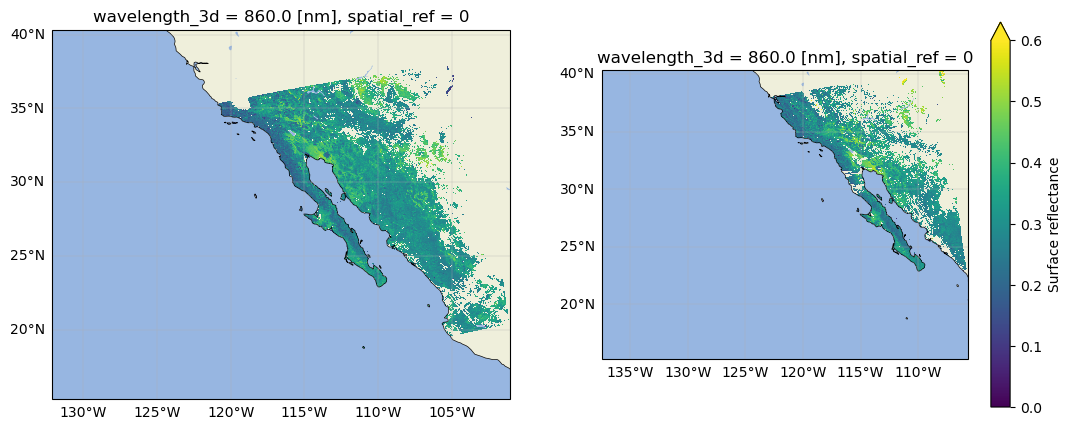

In [12]:
# TODO: Fix these?? hvplot instead?
fig, ax = plt.subplots(1,2, figsize=(13,5),sharey=True, 
                       subplot_kw={"projection": ccrs.PlateCarree()})
oci_pre["rhos"].sel(wavelength_3d=860, method="nearest").plot(ax=ax[0],vmin=0, vmax=0.6, add_colorbar=False)
oci_post["rhos"].sel(wavelength_3d=860, method="nearest").plot(ax=ax[1],vmin=0, vmax=0.6)
plot_features(ax[0])
plot_features(ax[1])
plt.show()

Clearly, OCI covers a much wider area than EMIT does (but of course at a much coarser resolution). The goal of this tutorial series is to do a burn analysis of the LA area, so let's subset our gridded data (which will also shrink these pretty large datasets and make them more memory-manageable).

In [13]:
# Subset PACE
oci_pre_sub = oci_pre.sel({"latitude":slice(34.5,33.6), "longitude":slice(-119.25,-117.5)})
oci_post_sub = oci_post.sel({"latitude":slice(34.5,33.6), "longitude":slice(-119.25,-117.5)})

# Subset EMIT
emit_pre_sub = emit_pre.sel({"latitude":slice(34.5,33.6), "longitude":slice(-119.25,-117.5)})
emit_post_sub = emit_post.sel({"latitude":slice(34.5,33.6), "longitude":slice(-119.25,-117.5)})

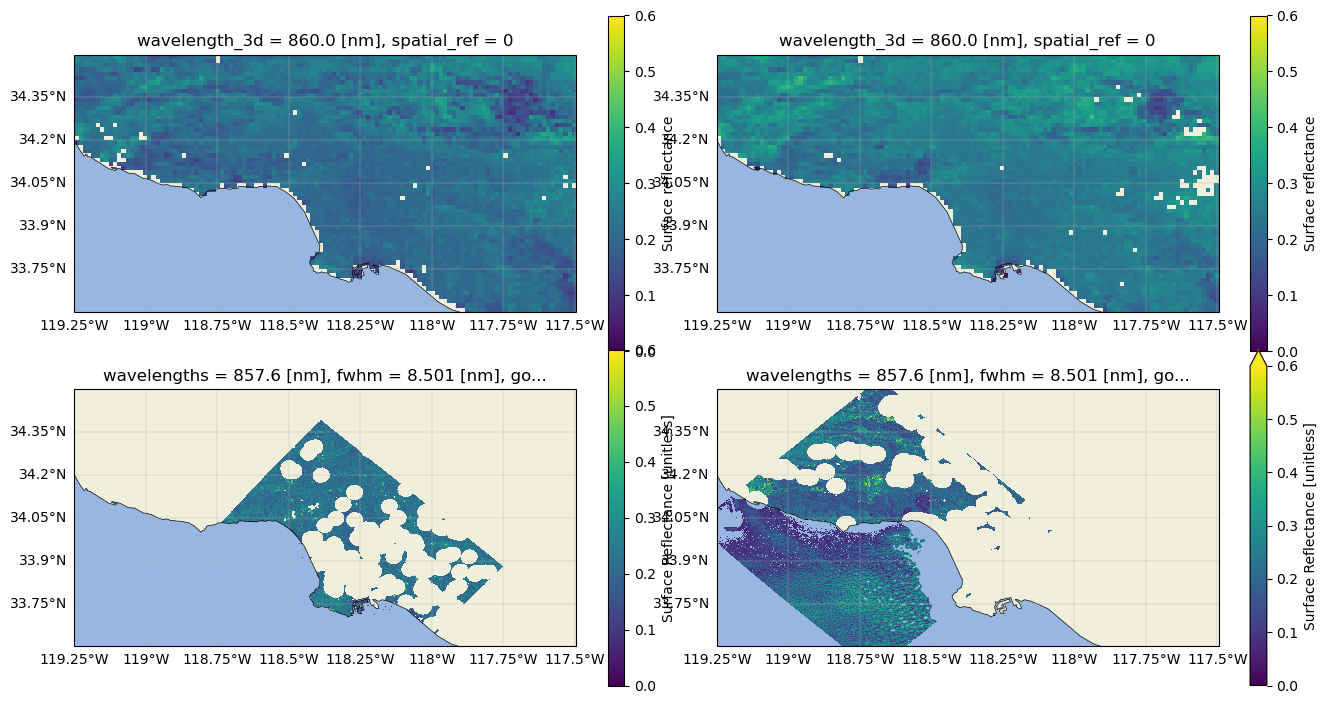

In [14]:
# TODO: Fix these?? hvplot instead?
fig, ax = plt.subplots(2,2, figsize=(13,7),sharey=True, sharex=True, 
                       subplot_kw={"projection": ccrs.PlateCarree()})
fig.tight_layout()
oci_pre_sub["rhos"].sel(wavelength_3d=860, method="nearest").plot(ax=ax[0][0],vmin=0, vmax=0.6)
oci_post_sub["rhos"].sel(wavelength_3d=860, method="nearest").plot(ax=ax[0][1],vmin=0, vmax=0.6)
emit_pre_sub["reflectance"].sel(wavelengths=860, method="nearest").plot(ax=ax [1][0],vmin=0, vmax=0.6)
emit_post_sub["reflectance"].sel(wavelengths=860, method="nearest").plot(ax=ax[1][1],vmin=0, vmax=0.6)
plot_features(ax[0][0])
plot_features(ax[0][1])
plot_features(ax[1][0])
plot_features(ax[1][1])
plt.show()

Let's export our datasets so we can continue working with them without repeating these steps each time.

In [15]:
#oci_pre_sub.to_netcdf("subset_data/oci_prefire.nc")
#oci_post_sub.to_netcdf("subset_data/oci_postfire.nc")
#emit_pre_sub.to_netcdf("subset_data/emit_prefire.nc")
#emit_post_sub.to_netcdf("subset_data/emit_postfire.nc")

### 4. Aligning PACE and EMIT Grids 
The case study example in `03_NBR_with_PACE_EMIT.ipynb` doesn't require PACE and EMIT to be on the same grid as we are going to illustrate the complimentary nature of the instruments' temporal, spatial, and spectral resolutions. However, there may be times when you want to align grids (and therefore, resolutions) between these two instruments. We'll take our post-fire subsets from OCI and EMIT and demonstrate how to align their grids below using a modified version of the `grid_data` function in the `pace_tools` module. 

If we zoom in close enough, we can see the difference in pixel size between PACE and EMIT:

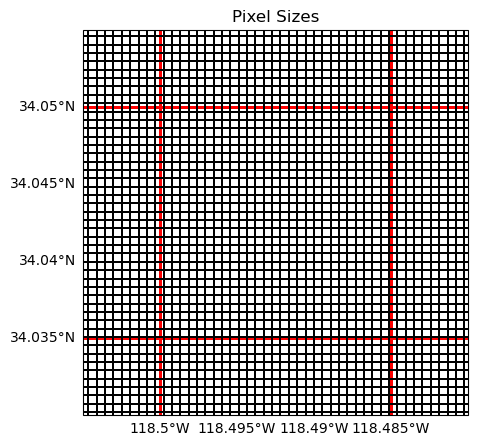

In [16]:
# This figure is kind of hard to see but helps me visually understand the 
#   different pixel sizes, can delete if not needed though
fig, ax = plt.subplots(figsize=(13,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
oci_post_sub.rhos.sel({"wavelength_3d":860}, method="nearest").plot(vmin=-1, vmax=0, cmap="Greys_r", transform=ccrs.PlateCarree(),linewidth=2, edgecolors="red", add_colorbar=False)
emit_post_sub.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="viridis", transform=ccrs.PlateCarree(),  linewidth=0.05, edgecolors="k", add_colorbar=False, alpha=1)
ax.set_extent([-118.505, -118.48, 34.03, 34.055])
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, alpha=0.0)
ax.set_title("Pixel Sizes")
plt.show()

The red lines above show a PACE pixel, while they grey lines outline each EMIT pixel within those PACE pixels. EMIT is clearly much finer, but we knew that going in! We can use the `grid_data` function to make EMIT coarser or to sharpen PACE pixels. For the latter case, the important thing to remember is that just because we put the data on a finer grid doesn't mean the data itself will be at a finer resolution. In other words, we will just be splitting that one value that started as a 0.015 degree pixel into multiple other pixels, but the one value will still be the same. 

<div class="alert alert-warning" role="alert">

Rewrite the above explanation/warning about pixel resolutions. Also, examples for why you'd want to coarsen/sharpen the grids in the first place

</div>

Let's regrid the PACE data to a finer resolution and see what this means. We'll use the Affine transform from the EMIT data to grab its spatial resolution, and we'll use it's CRS as our destination CRS. Note that both of these datasets use EPSG 4326, so the defaults in the `grid_data` function would be fine, but we'll set them explicitly to be thorough.

In [21]:
oci_finer = pace.grid_data(src=oci_post_sub, 
                           dst_transform=emit_post_sub.rio.transform())

changed res to user suppler (0.0005422325202563662, 0.0005422325202563684)


Check that the pixels align:

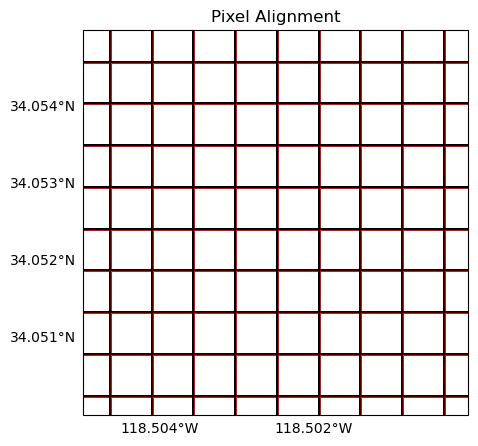

In [23]:
# This figure is kind of hard to see but helps me visually understand the 
#   different pixel sizes, can delete if not needed though
fig, ax = plt.subplots(figsize=(13,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
oci_finer.rhos.sel({"wavelength_3d":860}, method="nearest").plot(vmin=-1, vmax=0, cmap="Greys_r", transform=ccrs.PlateCarree(),linewidth=2, edgecolors="red", add_colorbar=False)
emit_post_sub.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="viridis", transform=ccrs.PlateCarree(),  linewidth=0.05, edgecolors="k", add_colorbar=False, alpha=1)
ax.set_extent([-118.505, -118.50, 34.05, 34.055])
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, alpha=0.0)
ax.set_title("Pixel Alignment")
plt.show()

We can see the pixels are aligned, so let's plot each granule on the same map. 

COMMENT ABOUT how we haven't "found" any new PACE data to sharpen the image, all the regridding to higher res does is make the pixels smaller and locate them to specific lat/lons. Useful for comparing spectra from certain locations, and untangling subpixel dynamics. The plot several spectra. Can go into scaling EMIT up as well?? 

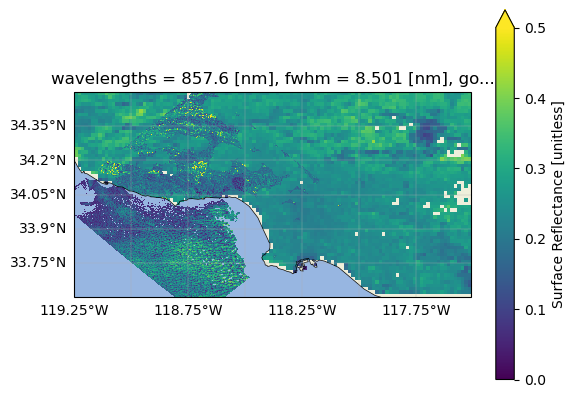

In [26]:
# TODO: Fix these?? hvplot instead?
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
oci_finer["rhos"].sel(wavelength_3d=860, method="nearest").plot(vmin=0, vmax=0.5,add_colorbar=False)
emit_post_sub["reflectance"].sel(wavelengths=860, method="nearest").plot(vmin=0, vmax=0.5)
plot_features(ax=ax)
plt.show()


Note that this method will subset the larger PACE scene to the EMIT boundaries, 

## 4. Regridding EMIT Data to Match PACE Resolution

do the same as above in reverse for EMIT? 

In [13]:
# TODO: Make one fcn that works for both gridding pace and regridding emit?
def regrid_emit_data(src, resolution, dst_crs="epsg:4326", resampling=Resampling.nearest):
    """
    Reproject a L2 OCI dataset to match an input grid. Makes sure 3D variables are
        in (Z, Y, X) dimension order, and all variables have spatial dims/crs 
        assigned.
    Args:
        src - an xarray dataset or dataarray to reproject
        resolution - resolution of the output grid, in dst_crs units
        dst_crs - CRS of the output data
        resampling - resampling method (see rasterio.enums)
    Returns:
        dst - projected xr dataset
    """
    if (len(list(src.dims)) == 3) and (list(src.dims)[0] != "wavelengths"):
        src = src.transpose("wavelengths", ...)

    # Aligning that transform to our desired resolution
    transform, width, height = rasterio.warp.aligned_target(transform=src.rio.transform(), 
                                                            width=src.rio.width, 
                                                            height=src.rio.height,
                                                            resolution=resolution)
    
    dst = src.rio.reproject(
        dst_crs=dst_crs,
        shape=(height, width),
        transform=transform,
        nodata=np.nan,
        resample=resampling,
    )
    dst["x"] = dst["x"].round(9)
    dst["y"] = dst["y"].round(9)
    
    return dst.rename({"x":"longitude", "y":"latitude"})

emit_p015 = regrid_emit_data(emit, resolution=(0.015, 0.015), dst_crs=emit.rio.crs)
emit_p015

<xarray.Dataset> Size: 7MB
Dimensions:           (longitude: 82, latitude: 71, wavelengths: 285)
Coordinates:
  * longitude         (longitude) float64 656B 128.4 128.4 128.5 ... 129.6 129.6
  * latitude          (latitude) float64 568B -28.1 -28.12 ... -29.14 -29.15
    good_wavelengths  (wavelengths) float32 1kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    fwhm              (wavelengths) float32 1kB 8.415 8.415 ... 8.807 8.809
  * wavelengths       (wavelengths) float32 1kB 381.0 388.4 ... 2.493e+03
    spatial_ref       int64 8B 0
Data variables:
    reflectance       (wavelengths, latitude, longitude) float32 7MB nan ... nan
Attributes: (12/40)
    ncei_template_version:             NCEI_NetCDF_Swath_Template_v2.0
    summary:                           The Earth Surface Mineral Dust Source ...
    keywords:                          Imaging Spectroscopy, minerals, EMIT, ...
    Conventions:                       CF-1.63
    sensor:                            EMIT (Earth Surface Mineral Dust Sourc...
    instrument:                        EMIT
    ...                                ...
    spatial_ref:                       GEOGCS["WGS 84",DATUM["WGS_1984",SPHER...
    geotransform:                      [ 1.28419905e+02  5.42232520e-04 -0.00...
    day_night_flag:                    Day
    title:                             EMIT L2A Estimated Surface Reflectance...
    granule_id:                        EMIT_L2A_RFL_001_20250117T041449_25017...
    Orthorectified:                    True

In [14]:
emit_p015.rio.transform()

Affine(0.015, 0.0, 128.41500000000002,
       0.0, -0.015, -28.095)

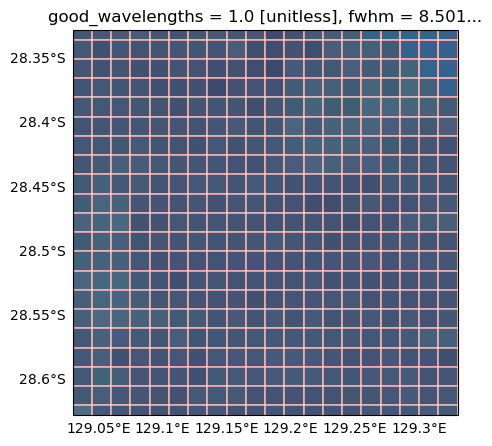

In [18]:
# Plot overlapping to show same size pixels
#TODO: Add bg cartopy elements, and maybe do this above to not be repetitive
fig, ax = plt.subplots(figsize=(13,5), subplot_kw=dict(projection=ccrs.PlateCarree()))
oci_gridded.rhos.sel({"wavelength_3d":860}, method="nearest").plot(vmin=0, vmax=1, transform=ccrs.PlateCarree(),linewidth=0.05, edgecolors="red", add_colorbar=False)
emit_p015.reflectance.sel({"wavelengths":860}, method="nearest").plot(vmin=0, vmax=1, cmap="Greys_r", transform=ccrs.PlateCarree(),  linewidth=0.05, edgecolors="white", add_colorbar=False, alpha=0.4)
#ax.set_extent([emit_p015.longitude.min(), emit_p015.longitude.min()+0.03, emit_p015.latitude.min(), emit_p015.latitude.min()+0.03])
ax.set_extent([emit_p015.longitude.median(), emit_p015.longitude.median()+0.3, emit_p015.latitude.median(), emit_p015.latitude.median()+0.3])
ax.gridlines(draw_labels={"left": "y", "bottom": "x"}, alpha=0.0)
plt.show()

## 5. Comparing the Data

Now we can compare some spectra from the same locations

In [19]:
# Subset:
oci_sub = oci_gridded.sel({"longitude": slice(emit_p015.longitude.median(), emit_p015.longitude.median()+0.3),
                         "latitude": slice(emit_p015.latitude.median()+0.3, emit_p015.latitude.median())})
emit_sub = emit_p015.sel({"longitude": slice(emit_p015.longitude.median(), emit_p015.longitude.median()+0.3),
                         "latitude": slice(emit_p015.latitude.median()+0.3, emit_p015.latitude.median())})
oci_sub

<xarray.Dataset> Size: 210kB
Dimensions:        (longitude: 20, latitude: 21, wavelength_3d: 122)
Coordinates:
  * longitude      (longitude) float64 160B 129.0 129.1 129.1 ... 129.3 129.3
  * latitude       (latitude) float64 168B -28.33 -28.34 ... -28.61 -28.63
  * wavelength_3d  (wavelength_3d) float64 976B 346.0 351.0 ... 2.258e+03
    spatial_ref    int64 8B 0
Data variables:
    rhos           (wavelength_3d, latitude, longitude) float32 205kB 0.04865...
    l2_flags       (latitude, longitude) float64 3kB 2.0 2.0 2.0 ... 2.0 2.0 2.0
Attributes: (12/47)
    title:                             OCI Level-2 Data SFREFL
    product_name:                      PACE_OCI.20250117T044314.L2.SFREFL.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data12/sdpsoper/vdc/vpu11/w...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                112.491745
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     1.0332738161087036
    geospatial_bounds:                 POLYGON ((137.16154 -12.55706, 112.491...

In [33]:
pts = list(zip(oci_sub.latitude.data,oci_sub.longitude.data))
#list(pts)

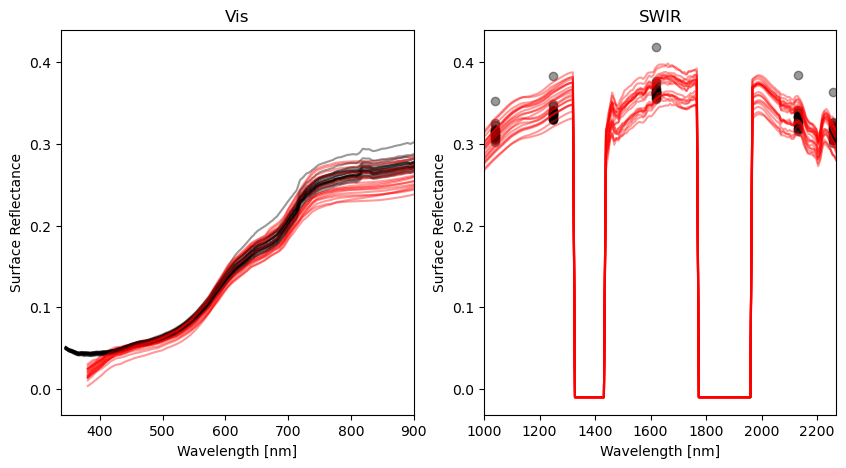

In [20]:
# TODO: Make a plot function for this
#       or make a better fun holoviews plot for it
pts = zip(oci_sub.latitude.data,oci_sub.longitude.data)

fig, ax = plt.subplots(1, 2, figsize=(10,5))

for pt in pts:
    ax[0].plot(oci_sub.wavelength_3d, oci_sub.rhos.sel({"latitude":pt[0], "longitude":pt[1]}), 
               alpha=0.4, c='k', label='OCI')
    ax[0].plot(emit_sub.wavelengths, emit_sub.reflectance.sel({"latitude":pt[0], "longitude":pt[1]}), 
               alpha=0.4, c='r', label='EMIT')
    ax[1].scatter(oci_sub.wavelength_3d, oci_sub.rhos.sel({"latitude":pt[0], "longitude":pt[1]}),
                   alpha=0.4, c='k', label='OCI')
    ax[1].plot(emit_sub.wavelengths, emit_sub.reflectance.sel({"latitude":pt[0], "longitude":pt[1]}),
                alpha=0.4, c='r', label='EMIT')
#ax[0].set_ylim([0.0, 1.1])
ax[0].set_xlim([339, 900])
ax[0].set_title("Vis")
ax[0].set_xlabel("Wavelength [nm]")
ax[0].set_ylabel("Surface Reflectance")

#ax[1].set_ylim([0.0, 0.1])
ax[1].set_xlim([1000, 2270])
ax[1].set_title("SWIR")
ax[1].set_xlabel("Wavelength [nm]")
ax[1].set_ylabel("Surface Reflectance")
plt.show()